# HW3

### Random Data Generator

- univariate gaussian data

- polynomial basis linear model

### Sqeuential estimate the mean and variance

### Baysian Linear regression

In [11]:
import math
import random
import matplotlib.pyplot as plt
from IPython.display import Latex, Markdown, Pretty
import pandas as pd
import numpy as np

In [2]:
def Mean(x):
    return sum(x) / len(x)

def Variance(x):
    u = Mean(x)
    return sum([(i - u)**2 for i in x]) / len(x)
    
def Covariance(x, y):
    ux = Mean(x)
    uy = Mean(y)
    return sum([(x[i] - ux)*(y[i] - uy) for i in range(len(x))]) / len(x)

class mylogging():
    def __init__(self, output=False, nolog=False):
        self.logs = ""
        self.output = output
        self.nolog = nolog
    
    def info(self, s):
        if self.output:
            print(s)
        if not self.nolog:
            self.logs += s + "\n"

### Random Data Generator

#### univariate gaussian data

- INPUT : expectation value $u$, variance $\sigma^2$
- OUTPUT : one outcome

all outcome will distribute like $N(u,\sigma^2)$

##### Marsaglia polar method

$$ \\
-1 \underline{<} U , V \underline{<} 1, S = U^2+V^2 \\
X = U\sqrt{\frac{-2\ln S}{S}}, Y = V\sqrt{\frac{-2\ln S}{S}}, when \space S < 1
$$

In [3]:
def Marsaglia():
    while True:
        U = random.random()*2-1
        V = random.random()*2-1
        if (U**2)+(V**2) < 1:
            break
    
    S = (U**2)+(V**2)
    S = math.sqrt((-2*math.log(S))/S)
    return (U*S, V*S)

def GaussianDataGenerator(u, v):
    sigma = math.sqrt(v)
    while True:
        D1, D2 = Marsaglia()
        yield u + sigma*D1
        yield u + sigma*D2

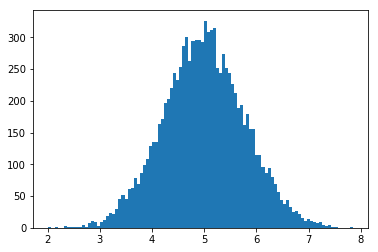

[4.997524947259819, 0.6049442640827968]

In [4]:
GDG = GaussianDataGenerator(5, 0.6)

Gdatas = [next(GDG) for _ in range(10000)]

plt.hist(Gdatas, 100)
plt.show()
[Mean(Gdatas), Variance(Gdatas)]

#### polynomial basis linear model

$$ y=w^TPhi(x)+e;e \sim N(0,\sigma^2) \\
w^TPhi(x) = \sum_{i}^{n} w_ix^i
$$

- INPUT : error variance $\sigma^2$, weight $w$,basis number $n$ for $Phi(x)$
- OUTPUT : one data point $(x,y)$
- NOTE : $ -10.0 < x < 10.0 $

In [5]:
def Gaussian(u, v):
    return lambda x : (math.exp(-1*(((x - u)**2) / (2*v) ) ) / math.sqrt(2*math.pi*v))

def Polynomial(w):
    return lambda x : sum([w[i]*(x**i) for i in range(len(w))])

def PolynomialDataGenerator(n, v, w):
    if len(w) != n:
        raise TypeError("length of w need equal n, {}!={}".format(len(w), n))
    e = GaussianDataGenerator(u=0,v=v)
    phi = Polynomial(w)
    while True:
        x = random.random()*20 - 10
        y = phi(x) + next(e)
        yield (x, y)

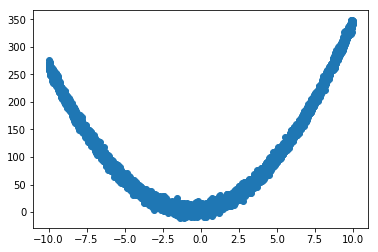

In [6]:
dg = PolynomialDataGenerator(3, 25, [5, 4, 3])
tmp = [next(dg) for _ in range(10000)]
x = [item[0] for item in tmp]
y = [item[1] for item in tmp]

plt.scatter(x, y)
plt.show()

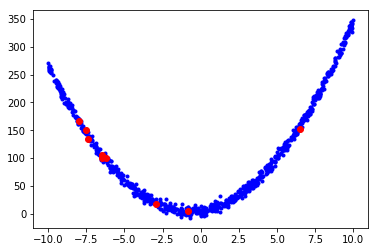

CPU times: user 30.2 s, sys: 22.2 s, total: 52.4 s
Wall time: 17.7 s


In [7]:
%%time
from IPython.display import clear_output
import time 
dg = PolynomialDataGenerator(n=3,v=10000,w=[0,1,0.01])
point_count = 1000
show_per_count = 10
data_x = []
data_y = []
show_x = []
show_y = []
for datapoint in tmp:
    x, y = datapoint
    
    if point_count % show_per_count == 0:
        plt.plot(data_x, data_y, 'b.')
        plt.plot(show_x, show_y, 'ro')
        plt.show()
        #time.sleep(0.5)
        data_x += show_x
        show_x = []
        data_y += show_y
        show_y = []
    else:
        show_x.append(x)
        show_y.append(y)
    
    point_count -= 1
    if point_count == 0:
        break;
    if point_count % show_per_count == 0:
        clear_output(wait=True)

### Sqeuential estimate the mean and variance

- INPUT : expectation value $u$, variance $\sigma^2$
- FUNCTION : find cureent estimates, repeat until the estimates converge
- OUTPUT : print new data point and cureent estimates each iteration

In [8]:
def NaiveEstimate():
    u = 0
    v = 1
    n = 0
    data_sum = 0
    data_sum2 = 0
    while True:
        new_data = (yield (u, v))
        n += 1
        data_sum += new_data
        data_sum2 += new_data**2
        u = data_sum / n
        v = (data_sum2 / n) - (u**2)

def SqeuentialEstimate(dg, es=NaiveEstimate):
    current_u = 0
    current_v = 1
    es = es()
    current_u, current_v = next(es)
    while True:
        new_data = next(dg)
        current_u, current_v = es.send(new_data)
        yield (new_data, current_u, current_v)

In [9]:
def test_SqeuentialEstimate(u, v, converge_threshold = 10**-2, times=1, max_iter=10000, output=False, output_rate = 1):
    iter_counts = []
    dg = GaussianDataGenerator(u, v)
    mylog = mylogging(output)
    
    while times != 0:
        iter_count = 0
        se = SqeuentialEstimate(dg)
        prev_u = None
        prev_v = None
        
        mylog.info("\n"+"="*10+"Test Start"+"="*10+"\n")
        
        for estimate in se:
            iter_count += 1
            new_data, next_u, next_v = estimate
            if (iter_count-1) % output_rate == 0:
                mylog.info("[{:5d}] new data : {:.3f}\tcurrent(u,v):({:.3f}, {:.3f})".format(
                    iter_count,
                    new_data,
                    next_u,
                    next_v,))
            if prev_u != None and prev_v != None:
                if abs(next_u - prev_u) <= converge_threshold and abs(next_v - prev_v) <= converge_threshold:
                    break

            if iter_count > max_iter and max_iter != -1:
                break;
            
            prev_u = next_u
            prev_v = next_v
                
        mylog.info("\n"+"="*10+"Test   End"+"="*10+"\n")
        
        iter_counts.append(iter_count)
        
        times -= 1
        
    return (iter_counts, mylog.logs)

In [12]:
_, logs = test_SqeuentialEstimate(5, 0.6, times=2, output_rate=10)
Pretty(logs)


==========Test Start==========

[    1] new data : 6.113	current(u,v):(6.113, 0.000)
[   11] new data : 4.868	current(u,v):(4.879, 0.471)
[   21] new data : 5.538	current(u,v):(5.033, 0.723)
[   31] new data : 3.624	current(u,v):(5.040, 0.806)
[   41] new data : 4.852	current(u,v):(4.970, 0.757)
[   51] new data : 5.191	current(u,v):(4.991, 0.808)

==========Test   End==========


==========Test Start==========

[    1] new data : 5.883	current(u,v):(5.883, 0.000)
[   11] new data : 5.607	current(u,v):(5.059, 0.556)
[   21] new data : 4.677	current(u,v):(4.832, 0.736)
[   31] new data : 5.087	current(u,v):(4.818, 0.570)
[   41] new data : 4.271	current(u,v):(4.832, 0.544)
[   51] new data : 3.772	current(u,v):(4.883, 0.642)

==========Test   End==========



In [13]:
%%time
test_outputs,_ = test_SqeuentialEstimate(5, 0.6, times=1000)

CPU times: user 7.5 s, sys: 10.7 s, total: 18.2 s
Wall time: 18.2 s


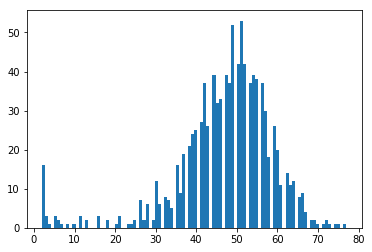

In [14]:
plt.hist(test_outputs, 100)
plt.show()

### Baysian Linear regression

- INPUT : for inital prior $\sim N(0, b^{-1}I)$ parameter $b$, error variance $\sigma^2$, weight $w$,basis number $n$ for $Phi(x)$
- FUNCTION : gen one data point and update prior and calculate the predictive distribution, repeat until the posterior converges
- OUTPUT : print the new data point and the current parameter for posterior and predictive distribution

$$\\
k : datapoints \space numbers \\
S^{-1} : prior \space covariance \space matrix , n*n\\
m : prior \space mean \space vector, n*1\\
X : design \space matrix, k*n \\
y_{pred} = Xw + error, k*1 \\
posterior_b = aX^TX + S = aX^TX + prior_b\\
w = posterior_u = posterior_b^{-1}(aX^Ty + Sm) = posterior_b^{-1}(aX^Ty + (prior_b)(prior_u)) \\
$$

#### Predictive distribution

$$ P(Y|\theta) = \int P(Y|w, \theta)P(w, \theta) \sim dw \\
P(Y|w, \theta) \sim N(Y|Xw, a^{-1}) \\
P(w, \theta) = Prior \sim N(W|u, b^{-1}) \\
P(Y|\theta) \sim N(Xw, a^{-1} + XbX^T) \\
$$

In [15]:
from MatrixOP import *
from Polynomial import *

In [16]:
def Design_Matrix(datas, N):
    # create matrix
    Design_X = [];
    Target_y = [];
    
    if type(datas) != list:
        datas = [datas]

    for index, row in enumerate(datas):
        x,y = row
        Design_X.append([basis(x, i) for i in range(N)])
        Target_y.append([y])
    
    return (Design_X,Target_y)

In [17]:
def BaysianLinearRegression(dataGenerator, likelihood_a, prior_u, prior_b):
    n = len(prior_u)
    input_u = prior_u
    input_b = prior_b
    
    
    while True:
        new_data = next(dataGenerator)
        X,y = Design_Matrix(new_data,n)
        
        # b' = aX^TX + b
        posterior_b = mul_matrix_scalar(likelihood_a, mul_matrix(tranpose_matrix(X), X))
        posterior_b = add_matrix(posterior_b, prior_b)
        # u' = b'^-1(aX^Ty + bu)
        posterior_u = add_matrix(mul_matrix_scalar(likelihood_a ,mul_matrix(tranpose_matrix(X), y)), mul_matrix(prior_b, prior_u))
        posterior_u = mul_matrix(inverse_matrix(posterior_b), posterior_u)
        
        reset = yield (new_data, posterior_u, posterior_b)

        if reset == True:
            prior_u = input_u
            prior_b = input_b
            yield (prior_u, prior_b)
        else:
            prior_u = posterior_u
            prior_b = posterior_b

In [18]:
def test_BaysianLinearRegression(BLR, target_equation=None, converge_threshold=10**-3, times=1, max_iter=10000, output=False, output_rate = 1):
    iter_counts = []
    plot_x = np.linspace(-10, 10, 1000)
    
    if target_equation:
        target_y = [target_equation.f(x) for x in plot_x];
    else:
        target_y = None
    mylog = mylogging(output)
    
    
    
    while times != 0:
        iter_count = 0
        data_x = []
        data_y = []
        test_over = False;
        
        # reset BLR
        next(BLR)
        prev_u, prev_b = BLR.send(True)
    
        mylog.info("\n"+"="*10+"Test Start"+"="*10+"\n")
        
        for regression in BLR:
            iter_count += 1
            x,y = regression[0]
            u = regression[1]
            b = regression[2]
            predict = polynomial_equation(u)
            
            
            # converge check
            All_converge = True
            distance_u = sub_matrix(u, prev_u)
            distance_b = sub_matrix(b, prev_b)
            for rows in distance_u:
                for item in rows:
                    if abs(item) > converge_threshold:
                        All_converge = False
                        break;
                
                if not All_converge:
                    break;
                
            if All_converge:
                test_over = True
                
            if iter_count >= max_iter and max_iter != -1:
                test_over = True
                
            if (iter_count-1) % output_rate == 0 or test_over:
                mylog.info("[{:5d}] new data(x,y) : ({:.3f}, {:.3f})".format(iter_count, x, y))
                mylog.info("\n predictive distribution : " + str(predict) + "\n")
                
                # plot
                if target_y:
                    clear_output(wait=True)
                    plt.plot(data_x, data_y, 'bo', markerfacecolor='none')
                    plt.plot(x, y, 'yo', markerfacecolor='none')
                    plt.plot(plot_x, target_y, 'g', label='target')
                    plt.plot(plot_x, [predict.f(x) for x in plot_x], 'r', label='predict')
                    plt.legend()
                    
                    plt.show()
            
            if test_over:
                break
            
            data_x.append(x)
            data_y.append(y)
                
            prev_u = u;
            prev_b = b;
        
        
        mylog.info("\n"+"="*10+"Test   End"+"="*10+"\n")
        iter_counts.append(iter_count)
        
        times -= 1
        
    return (iter_counts, mylog.logs)

In [19]:
# one test data w = [0, 0, 0, 0.01]
# input parameter
error_v = 5
w = [0, 0, 0, 0.01]
n = 4

# n*n
prior_b = tranpose_matrix(unit_matrix(n=n))
# n*1
prior_u = [[0] for _ in range(n)]
# likelihood gaussian variance
likelihood_a = 1

dg = PolynomialDataGenerator(n, error_v, w)
blr = BaysianLinearRegression(dg, 1, prior_u, prior_b)
target_e = polynomial_equation(w)

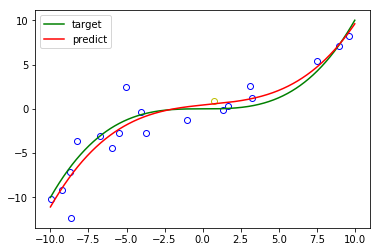

[20]



==========Test Start==========

[    1] new data(x,y) : (1.333, -0.160)

 predictive distribution : $$y = -0.03x^3-0.02x^2-0.02x^1-0.01$$

[    2] new data(x,y) : (-9.946, -10.200)

 predictive distribution : $$y = +0.01x^3-0.05x^2-0.03x^1-0.02$$

[    3] new data(x,y) : (8.963, 7.128)

 predictive distribution : $$y = +0.01x^3-0.00x^2-0.06x^1-0.05$$

[    4] new data(x,y) : (9.630, 8.259)

 predictive distribution : $$y = +0.01x^3-0.00x^2+0.08x^1-0.12$$

[    5] new data(x,y) : (-6.742, -3.100)

 predictive distribution : $$y = +0.01x^3-0.00x^2-0.02x^1-0.04$$

[    6] new data(x,y) : (7.530, 5.366)

 predictive distribution : $$y = +0.01x^3-0.00x^2+0.12x^1+0.11$$

[    7] new data(x,y) : (-5.494, -2.766)

 predictive distribution : $$y = +0.01x^3-0.00x^2+0.18x^1+0.01$$

[    8] new data(x,y) : (-4.023, -0.350)

 predictive distribution : $$y = +0.01x^3-0.00x^2+0.13x^1+0.16$$

[    9] new data(x,y) : (-5.035, 2.476)

 predictive distribution : $$y = +0.01x^3-0.01x^2-0.07x^1+0.51$$

[   10] new data(x,y) : (-1.031, -1.246)

 predictive distribution : $$y = +0.01x^3-0.00x^2-0.10x^1+0.09$$

[   11] new data(x,y) : (1.672, 0.347)

 predictive distribution : $$y = +0.01x^3-0.00x^2-0.08x^1+0.18$$

[   12] new data(x,y) : (-5.976, -4.374)

 predictive distribution : $$y = +0.01x^3-0.00x^2+0.03x^1+0.11$$

[   13] new data(x,y) : (-3.749, -2.721)

 predictive distribution : $$y = +0.01x^3-0.00x^2+0.09x^1-0.06$$

[   14] new data(x,y) : (-9.270, -9.146)

 predictive distribution : $$y = +0.01x^3-0.00x^2+0.08x^1-0.04$$

[   15] new data(x,y) : (-8.719, -7.094)

 predictive distribution : $$y = +0.01x^3-0.00x^2+0.08x^1-0.04$$

[   16] new data(x,y) : (-8.618, -12.310)

 predictive distribution : $$y = +0.01x^3-0.01x^2+0.10x^1+0.05$$

[   17] new data(x,y) : (3.115, 2.627)

 predictive distribution : $$y = +0.01x^3-0.01x^2+0.19x^1+0.39$$

[   18] new data(x,y) : (3.221, 1.246)

 predictive distribution : $$y = +0.01x^3-0.01x^2+0.20x^1+0.40$$

[   19] new data(x,y) : (-8.234, -3.669)

 predictive distribution : $$y = +0.01x^3-0.01x^2+0.17x^1+0.39$$

[   20] new data(x,y) : (0.738, 0.831)

 predictive distribution : $$y = +0.01x^3-0.01x^2+0.17x^1+0.43$$


==========Test   End==========



In [20]:
outcomes, logs = test_BaysianLinearRegression(blr, target_e, converge_threshold=10**-3,times=1, max_iter=20, output_rate=1)
print(outcomes)
Markdown(logs)

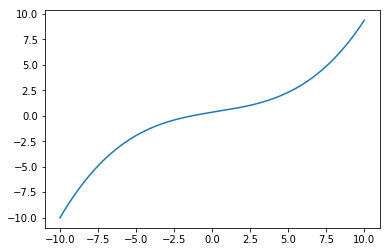

$$y = +0.01x^3-0.01x^2+0.24x^1+0.34$$

In [21]:
_, predict_w, _ = next(blr) 
predict_distribution = polynomial_equation(predict_w)
x = np.linspace(-10,10,1000)
plt.plot(x, [predict_distribution.f(i) for i in x])
plt.show()
Markdown(str(predict_distribution))

In [22]:
def Design_X(xs, n):
    if type(xs) != list:
        xs = [x]
    return [[basis(x,i) for i in range(n)] for x in xs]
    
def PredictiveDistribution(a, w, b):
    n = len(w)
    return lambda x: (mul_matrix(Design_X(x,n),w), add_matrix_scalar((1/a), mul_matrix(mul_matrix(Design_X(x,n), b), tranpose_matrix(Design_X(x,n)))) )

In [24]:
_, prior_w, prior_b = next(blr)
ypd = PredictiveDistribution(likelihood_a, prior_w, prior_b)
(prior_w, prior_b)

([[0.1196717529818101],
  [0.22019832623864488],
  [-0.0030478385052451484],
  [0.007479194173625817]],
 [[24.0, -58.735334561176685, 1010.1555573414078, -4216.0459674499925],
  [-58.735334561176685,
   1011.1555573414078,
   -4216.0459674499925,
   73721.71137088658],
  [1010.1555573414078,
   -4216.0459674499925,
   73722.71137088658,
   -328923.6433967124],
  [-4216.0459674499925,
   73721.71137088658,
   -328923.6433967124,
   6002559.960354587]])

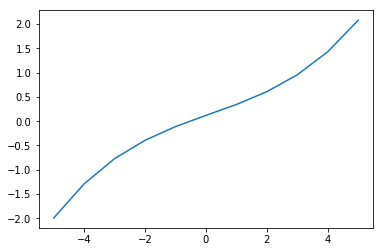

In [25]:
x = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
y,covar = ypd(x)
plt.plot(x,y)

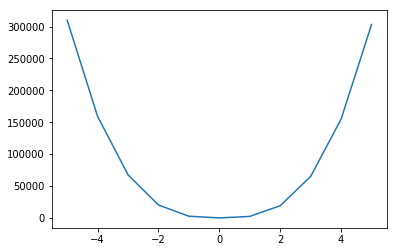

In [26]:
var = [covar[i][i] for i in range(len(covar))]
var = [math.sqrt(v) for v in var]
plt.plot(x, var)